<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import gdown
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Download some attributes

!gdown --id 1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y
To: /content/lfw_attributes.txt
100% 14.9M/14.9M [00:00<00:00, 154MB/s]


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Преобразуем в тензор и переставляем оси

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [ ]:
# Создание PyTorch датасета
image_dataset = ImageDataset(data)

# Разделение на train и val (80% / 20%)
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

# Загрузка данных
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Визуализация нескольких изображений
def show_images_from_loader(loader, num_images=8):
    images = next(iter(loader))[:num_images]  # Берем первую партию изображений
    images = images.permute(0, 2, 3, 1).numpy()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

Train Images:


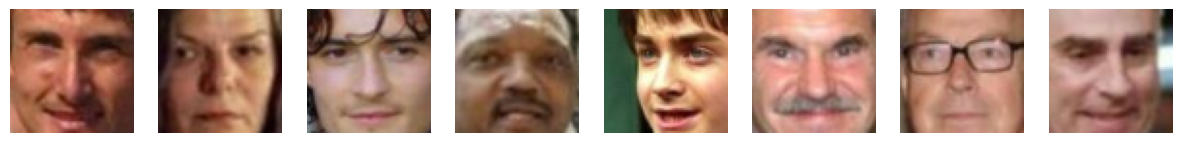

Validation Images:


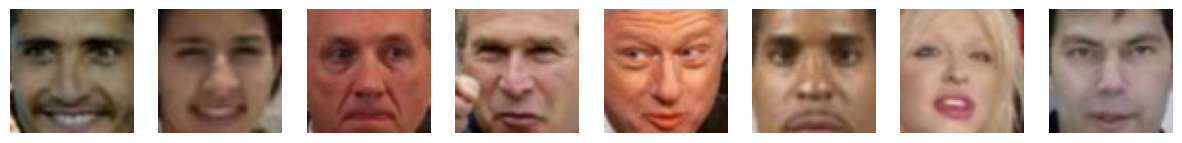

In [ ]:
# Визуализация
print("Train Images:")
show_images_from_loader(train_loader)

print("Validation Images:")
show_images_from_loader(val_loader)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, dim_code=64):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # -> (batch, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> (batch, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> (batch, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Flatten(),  # -> (batch, 128 * 8 * 8)
        )

        self.fc_encode = nn.Linear(128 * 8 * 8, dim_code)  # -> (batch, dim_code)

        # Decoder
        self.fc_decode = nn.Linear(dim_code, 128 * 8 * 8)  # -> (batch, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),  # -> (batch, 128, 8, 8)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> (batch, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> (batch, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # -> (batch, 3, 64, 64)
            nn.Sigmoid(),  # Для нормализации в диапазон [0, 1]
        )

    def forward(self, x):
        latent_code = self.fc_encode(self.encoder(x))
        reconstruction = self.decoder(self.fc_decode(latent_code))
        return reconstruction, latent_code

In [ ]:
criterion = criterion = nn.BCELoss()

autoencoder = Autoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        # Тренировка
        for images in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            reconstructions, _ = model(images)

            loss = criterion(reconstructions, images)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)

                reconstructions, _ = model(images)

                loss = criterion(reconstructions, images)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model(autoencoder, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda')

Epoch [1/20] - Train Loss: 0.5995, Val Loss: 0.6015
Epoch [2/20] - Train Loss: 0.5995, Val Loss: 0.6019
Epoch [3/20] - Train Loss: 0.5994, Val Loss: 0.6014
Epoch [4/20] - Train Loss: 0.5994, Val Loss: 0.6016
Epoch [5/20] - Train Loss: 0.5994, Val Loss: 0.6016
Epoch [6/20] - Train Loss: 0.5993, Val Loss: 0.6016
Epoch [7/20] - Train Loss: 0.5994, Val Loss: 0.6014
Epoch [8/20] - Train Loss: 0.5992, Val Loss: 0.6015
Epoch [9/20] - Train Loss: 0.5993, Val Loss: 0.6015
Epoch [10/20] - Train Loss: 0.5992, Val Loss: 0.6015
Epoch [11/20] - Train Loss: 0.5991, Val Loss: 0.6015
Epoch [12/20] - Train Loss: 0.5992, Val Loss: 0.6016
Epoch [13/20] - Train Loss: 0.5992, Val Loss: 0.6016
Epoch [14/20] - Train Loss: 0.5991, Val Loss: 0.6015
Epoch [15/20] - Train Loss: 0.5992, Val Loss: 0.6017
Epoch [16/20] - Train Loss: 0.5991, Val Loss: 0.6016
Epoch [17/20] - Train Loss: 0.5991, Val Loss: 0.6017
Epoch [18/20] - Train Loss: 0.5991, Val Loss: 0.6016
Epoch [19/20] - Train Loss: 0.5990, Val Loss: 0.6016
Ep

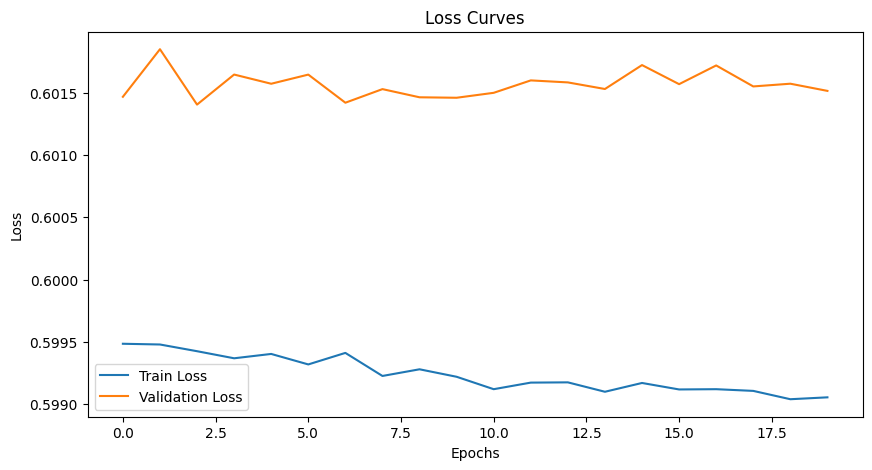

In [ ]:
    # Графики потерь
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curves")
    plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
def visualize_reconstruction(model, val_loader, num_images=5, device='cuda'):
  model.eval()
  images = next(iter(val_loader))  # Получаем несколько изображений из валидационного набора
  images = images.to(device)

  with torch.no_grad():
      # Получаем реконструкции
      reconstructions, _ = model(images)

  # Преобразуем изображения и реконструкции в numpy для отображения
  images = images.cpu().numpy()
  reconstructions = reconstructions.cpu().numpy()

  # Настройка для отображения
  fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
  for i in range(num_images):
      # Оригинальные изображения
      axes[i, 0].imshow(images[i].transpose(1, 2, 0))  # Переставляем оси (C, H, W) -> (H, W, C)
      axes[i, 0].set_title(f"Original {i+1}")
      axes[i, 0].axis('off')

      # Реконструкции
      axes[i, 1].imshow(reconstructions[i].transpose(1, 2, 0))  # Переставляем оси
      axes[i, 1].set_title(f"Reconstruction {i+1}")
      axes[i, 1].axis('off')

  plt.show()

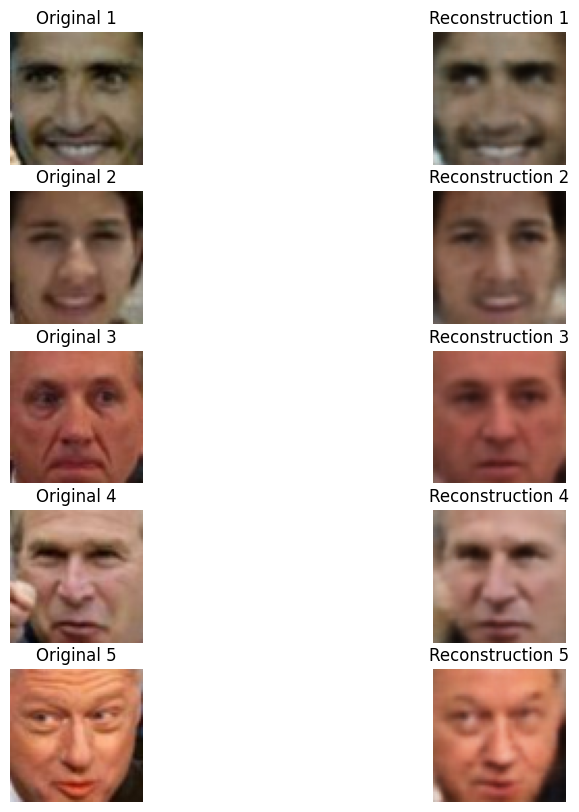

In [ ]:
visualize_reconstruction(autoencoder, val_loader, num_images=5, device='cuda')

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# Пропустим изображения через энкодер и соберем их латентные векторы
num_samples = 1000  # Количество изображений для выборки
latents = []

for i, images in enumerate(train_loader):
    if i * images.size(0) >= num_samples:
        break
    images = images.to(device)

    # Получаем латентные векторы для батча
    with torch.no_grad():
        latent_vectors = autoencoder.fc_encode(autoencoder.encoder(images))
        latents.append(latent_vectors.cpu().numpy())

# Преобразуем список в массив numpy
latents = np.concatenate(latents, axis=0)

# Вычисляем среднее и стандартное отклонение по каждой оси латентного пространства
mean_latent = np.mean(latents, axis=0)
std_latent = np.std(latents, axis=0)

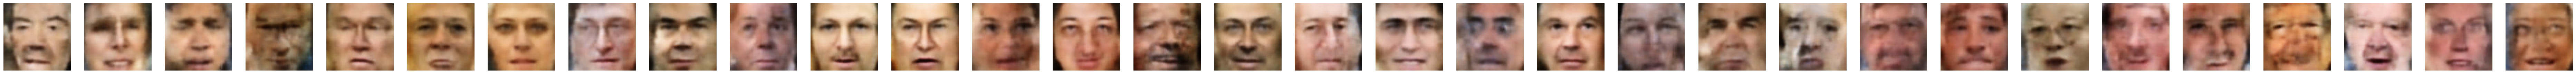

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Генерируем случайные векторы из стандартного нормального распределения
random_latent_vectors = np.random.randn(batch_size, dim_code) * std_latent + mean_latent
random_latent_vectors = torch.tensor(random_latent_vectors, dtype=torch.float32).to(device)

# Передаем эти векторы через декодер
with torch.no_grad():
    generated_images = autoencoder.decoder(autoencoder.fc_decode(random_latent_vectors))

# Меняем оси для matplotlib (batch, height, width, channels)
generated_images = generated_images.permute(0, 2, 3, 1).cpu().numpy()

# Устанавливаем размеры изображений, например, 5 дюймов на изображение
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 5))

for i in range(batch_size):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')

plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs['Smiling'] # Колонка с улабющимися людьми

,Smiling
0,-0.86499
1,0.798544
2,0.172817
3,0.563327
4,0.507786
...,...
13138,-1.001434
13139,-0.64957
13140,0.475018
13141,0.741653


In [ ]:
# Отбираем людей с положительным значением в колонке "Smiling"
smiling_people_indices = attrs[attrs["Smiling"] > 0].index

# Теперь у нас есть индексы людей, которые улыбаются
print("Количество улыбающихся людей:", len(smiling_people_indices))
print("Пример индексов улыбающихся людей:", smiling_people_indices[:10])

Количество улыбающихся людей: 5432
Пример индексов улыбающихся людей: Index([1, 2, 3, 4, 5, 8, 9, 11, 18, 23], dtype='int64')


In [ ]:
# Отбираем людей с отрицательным значением в колонке "Frowning"
frowning_people_indices = attrs[attrs["Frowning"] > 0].index

# Теперь у нас есть индексы людей, которые грустят
print("Количество грустных людей:", len(frowning_people_indices))
print("Пример индексов грустных людей:", frowning_people_indices[:10])

Количество грустных людей: 7640
Пример индексов грустных людей: Index([0, 2, 6, 7, 10, 12, 13, 14, 15, 16], dtype='int64')


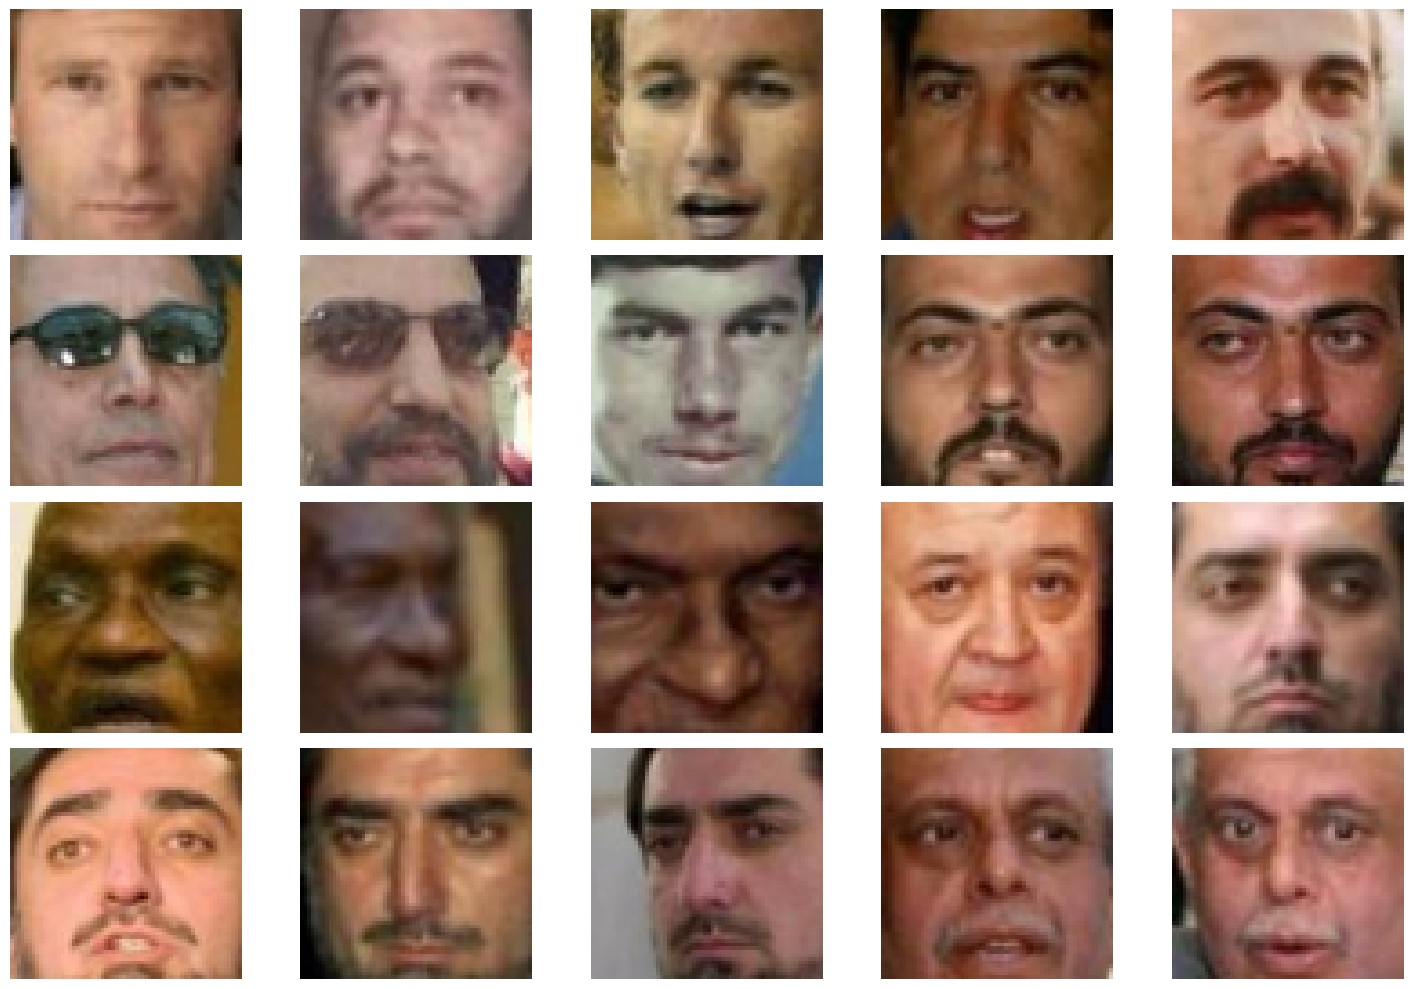

In [ ]:
# Отобразим первые 20 изображений грустных людей, чтобу убедиться, что мы их корректно отобрали
num_images_to_display = 20

selected_images = [data[idx] for idx in frowning_people_indices [:20]]

# Отображаем изображения
fig, axes = plt.subplots(4, 5, figsize=(15, 10))

for i, img in enumerate(selected_images):
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Отбираем все изображения людей с улыбками и грустных людей, и обрабатываем их с помощью ImageDataset
smiling_images = ImageDataset(data[smiling_people_indices])
frowning_images = ImageDataset(data[frowning_people_indices])

In [ ]:
# Заполянем массивы латентных векторов для грустных и радостных людей
smiling_latent_vectors = []
frowning_latent_vectors = []

# Получение латентных векторов для улыбающихся людей
for img in smiling_images:
    latent_vector = autoencoder.fc_encode(autoencoder.encoder(img.unsqueeze(0).to(device)))
    smiling_latent_vectors.append(latent_vector.cpu().detach().numpy())

# Получение латентных векторов для грустных людей
for img in frowning_images:
    latent_vector = autoencoder.fc_encode(autoencoder.encoder(img.unsqueeze(0).to(device)))
    frowning_latent_vectors.append(latent_vector.cpu().detach().numpy())

# Преобразуем списки в numpy массивы
smiling_latent_vectors = np.array(smiling_latent_vectors)
frowning_latent_vectors = np.array(frowning_latent_vectors)

In [ ]:
# Подсчитываем средние векторы для массивов с латетными векторами
mean_smiling_latent = np.mean(smiling_latent_vectors, axis=0)
mean_frowning_latent = np.mean(frowning_latent_vectors, axis=0)

# Вектор улыбки
smile_vector = mean_smiling_latent - mean_frowning_latent

In [ ]:
# Применение улыбки к грустным людям
smiling_frowning_images = []

for latent_vector in frowning_latent_vectors:
    # Добавляем вектор улыбки
    modified_latent = latent_vector + smile_vector

    # Преобразуем в torch.Tensor и перемещаем на устройство
    modified_latent = torch.tensor(modified_latent).to(device).float()

    # Преобразуем модифицированный латентный вектор с помощью fc_decode
    with torch.no_grad():
        decoded_image = autoencoder.decoder(autoencoder.fc_decode(modified_latent))
        smiling_frowning_images.append(decoded_image.cpu().numpy())

# Преобразование результата в numpy для визуализации
smiling_frowning_images = np.array(smiling_frowning_images)

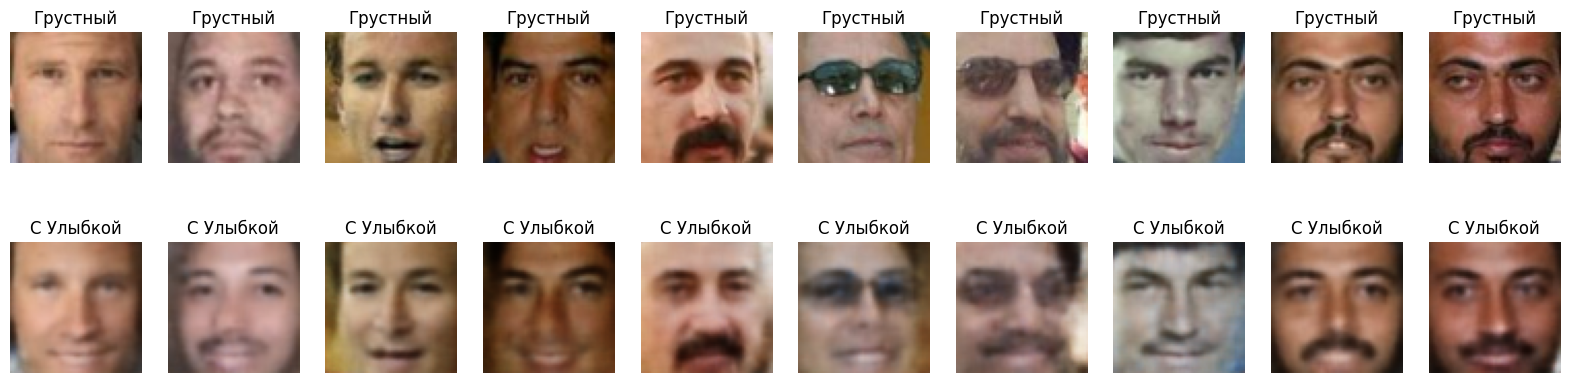

In [ ]:
# Отрисовываем грустных людей и этих же людей, но уже с улыбкой
# Ограничим вывод 10 изображениями
num_images_to_show = 10

fig, axs = plt.subplots(2, num_images_to_show, figsize=(20, 5))

for i, (original_img, smiling_img) in enumerate(zip(frowning_images[:num_images_to_show], smiling_frowning_images[:num_images_to_show])):
    axs[0, i].imshow(original_img.permute(1, 2, 0).cpu().numpy())
    axs[0, i].axis('off')
    axs[0, i].set_title("Грустный")

    axs[1, i].imshow(smiling_img.squeeze().transpose(1, 2, 0))
    axs[1, i].axis('off')
    axs[1, i].set_title("С Улыбкой")

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
import torch
from torchvision import datasets, transforms

In [4]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 140kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.44MB/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logsigma = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Outputs normalized to [0, 1]
        )

    def encode(self, x):
        features = self.encoder(x)
        mu = self.fc_mu(features)
        logsigma = self.fc_logsigma(features)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        reconstruction = self.fc_decoder(z)
        reconstruction = self.decoder(reconstruction)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [5]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [6]:
def train_vae(model, train_loader, val_loader, criterion, optimizer, num_epochs=40, device='cuda'):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()

            mu, logsigma, reconstruction = model(x)

            loss = criterion(x, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader.dataset))

        # Оценка на валидации
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)

                mu, logsigma, reconstruction = model(x)

                loss = criterion(x, mu, logsigma, reconstruction)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader.dataset))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [ ]:
criterion = loss_vae

autoencoder = VAE()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
train_losses, val_losses = train_vae(autoencoder, train_loader, test_loader, criterion, optimizer, num_epochs=40, device='cuda')

Epoch [1/40], Train Loss: 134.2014, Val Loss: 101.8711
Epoch [2/40], Train Loss: 110.6910, Val Loss: 98.6834
Epoch [3/40], Train Loss: 107.7310, Val Loss: 96.7246
Epoch [4/40], Train Loss: 106.3442, Val Loss: 96.2771
Epoch [5/40], Train Loss: 105.3843, Val Loss: 95.5520
Epoch [6/40], Train Loss: 104.6858, Val Loss: 94.9810
Epoch [7/40], Train Loss: 104.1529, Val Loss: 94.8398
Epoch [8/40], Train Loss: 103.7278, Val Loss: 93.9303
Epoch [9/40], Train Loss: 103.3694, Val Loss: 94.6654
Epoch [10/40], Train Loss: 103.0767, Val Loss: 93.2392
Epoch [11/40], Train Loss: 102.8349, Val Loss: 92.9979
Epoch [12/40], Train Loss: 102.6282, Val Loss: 93.7651
Epoch [13/40], Train Loss: 102.4157, Val Loss: 92.8565
Epoch [14/40], Train Loss: 102.2314, Val Loss: 92.2737
Epoch [15/40], Train Loss: 102.0753, Val Loss: 92.4556
Epoch [16/40], Train Loss: 101.8867, Val Loss: 92.5902
Epoch [17/40], Train Loss: 101.7589, Val Loss: 92.7832
Epoch [18/40], Train Loss: 101.5653, Val Loss: 92.1029
Epoch [19/40], Tra

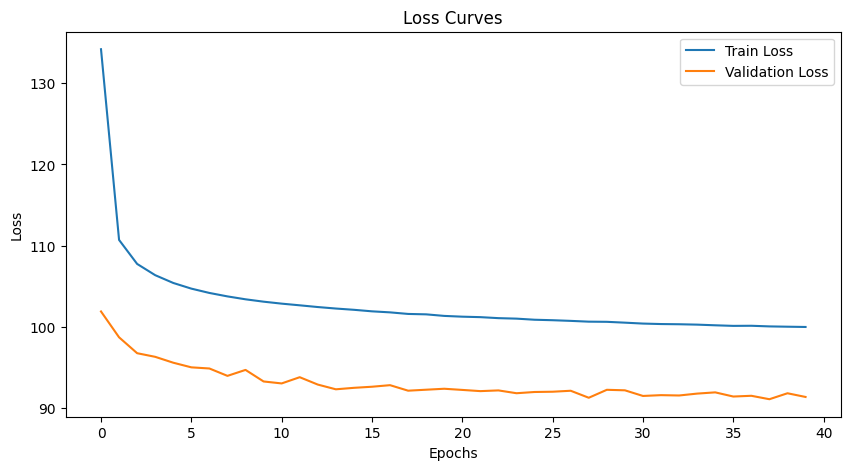

In [ ]:
# Графики потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

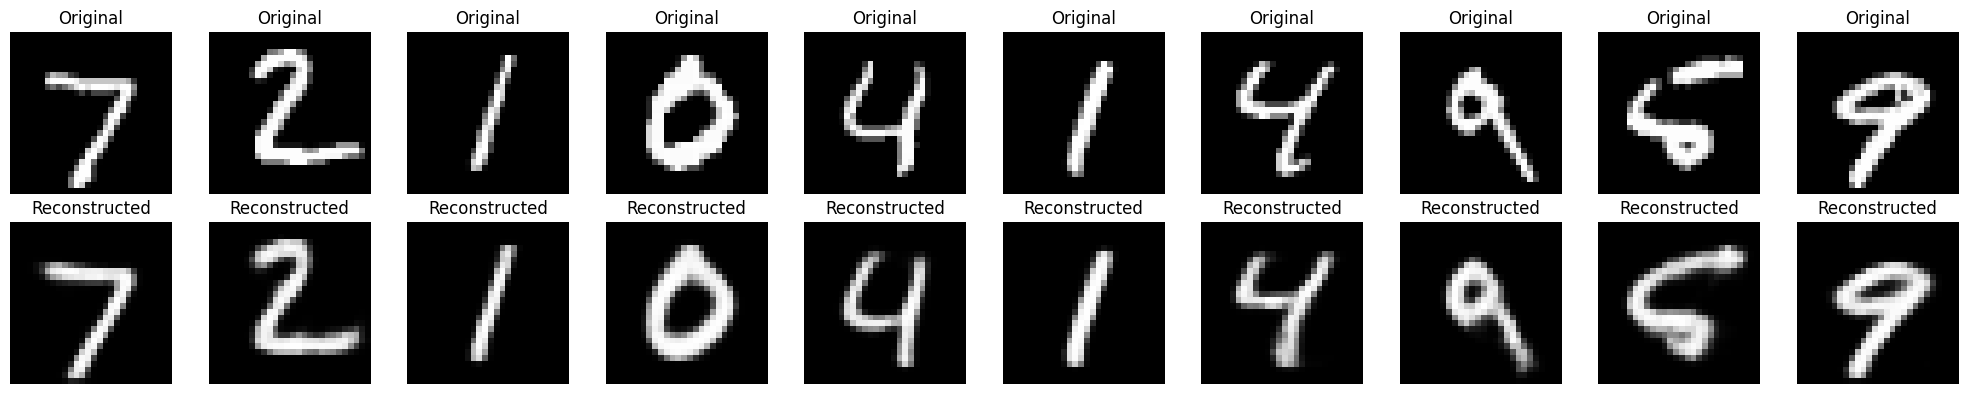

In [ ]:
import matplotlib.pyplot as plt

# Количество картинок для отображения
num_images = 10

autoencoder.eval()

# Получение картинок из тестовой выборки
data_iter = iter(test_loader)
images, _ = next(data_iter)
images = images.to(device)

# Кодирование и восстановление
with torch.no_grad():
    _, _, reconstructions = autoencoder(images)

# Переводим на CPU и убираем батч-нормализацию
images = images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

# Визуализация
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

for i in range(num_images):
    # Оригинальные картинки
    axes[0, i].imshow(images[i].squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Восстановленные картинки
    axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()


Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Убедимся, что модель в режиме оценки
autoencoder.eval()

# Количество выборок
num_samples = 1000  # Количество изображений для выборки
latents = []

# Сбор латентных векторов
for i, (images, _) in enumerate(train_loader):
    if i * images.size(0) >= num_samples:
        break
    images = images.to(device)

    # Пропускаем через энкодер, получаем mu и logsigma
    with torch.no_grad():
        mu, logsigma = autoencoder.encode(images)
        latent_vectors = autoencoder.gaussian_sampler(mu, logsigma)  # Получаем латентные векторы
        latents.append(latent_vectors.cpu().numpy())

# Объединяем все латентные векторы в один массив
latents = np.concatenate(latents, axis=0)

# Вычисляем среднее и стандартное отклонение по каждой оси латентного пространства
mean_latent = np.mean(latents, axis=0)
std_latent = np.std(latents, axis=0)

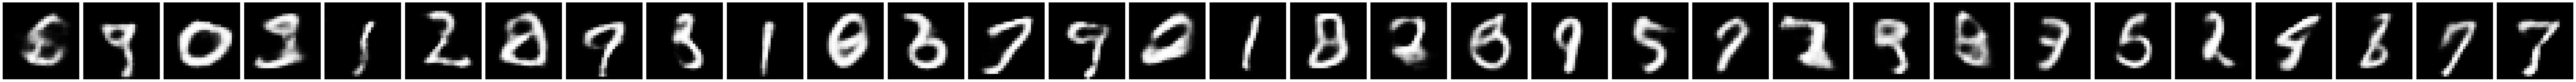

In [ ]:
# Генерация случайных латентных векторов из стандартного нормального распределения
dim_code = latents.shape[1]  # Размерность латентного пространства
random_latent_vectors = np.random.randn(batch_size, dim_code) * std_latent + mean_latent
random_latent_vectors = torch.tensor(random_latent_vectors, dtype=torch.float32).to(device)

# Передаем случайные латентные векторы через декодер
with torch.no_grad():
    generated_images = autoencoder.decode(random_latent_vectors)

# Переводим тензоры в формат для matplotlib
generated_images = generated_images.permute(0, 2, 3, 1).cpu().numpy()

# Отображаем сгенерированные изображения
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 5))

for i in range(batch_size):
    axs[i].imshow(generated_images[i].squeeze(), cmap="gray")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок цифр выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

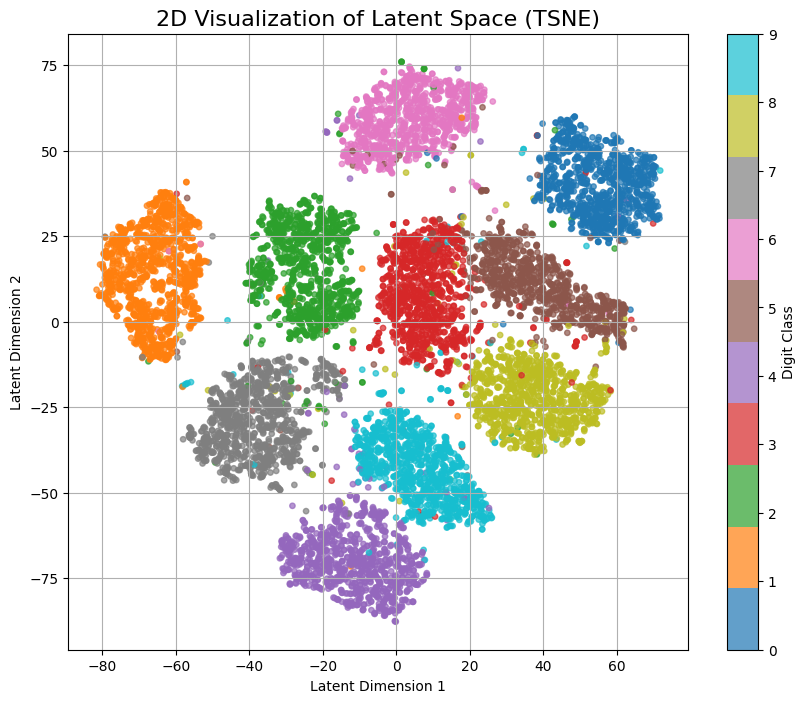

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Убедимся, что модель в режиме оценки
autoencoder.eval()

# Список для хранения латентных векторов и соответствующих меток
latents = []
labels = []

# Получаем латентные векторы для тестового датасета
for images, targets in test_loader:
    images = images.to(device)
    with torch.no_grad():
        mu, logsigma = autoencoder.encode(images)  # Получаем параметры латентного пространства
        latent_vectors = autoencoder.gaussian_sampler(mu, logsigma).cpu().numpy()  # Семплируем латентные векторы
        latents.append(latent_vectors)
        labels.append(targets.cpu().numpy())  # Сохраняем метки классов

# Преобразуем в numpy массивы
latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

# Используем TSNE для уменьшения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)

# Визуализируем латентные представления в 2D пространстве
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=15
)
plt.colorbar(scatter, label="Digit Class")
plt.title("2D Visualization of Latent Space (TSNE)", fontsize=16)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()

Что вы думаете о виде латентного представления?
Каждая точка на графике соответствует латентному вектору одного изображения из тестового набора данных. Цвета точек представляют классы цифр (от 0 до 9), что позволяет оценить, как распределяются латентные представления для каждой цифры. Латентные представления цифр формируют плотные кластеры, что говорит о том, что модель VAE успешно разделила классы в латентном пространстве.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

class CVAE(nn.Module):
    def __init__(self, latent_dim=64, num_classes=10):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0),  # 7x7 -> 4x4
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logsigma = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=1, padding=0),  # 4x4 -> 7x7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        # One-hot encoding для класса и конкатенация
        batch_size = x.size(0)
        class_onehot = F.one_hot(class_num, num_classes=10).float().view(batch_size, 10, 1, 1)
        class_onehot = class_onehot.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, class_onehot], dim=1)

        x = self.encoder(x)
        x = x.view(batch_size, -1)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_num):
        # One-hot encoding для класса и конкатенация
        batch_size = z.size(0)
        class_onehot = F.one_hot(class_num, num_classes=10).float()
        z = torch.cat([z, class_onehot], dim=1)

        z = self.fc_decoder(z)
        z = z.view(batch_size, 128, 4, 4)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [7]:
def train_cvae(model, train_loader, val_loader, criterion, optimizer, num_epochs=40, device='cuda'):

    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            mu, logsigma, reconstruction = model(x, y)

            loss = criterion(x, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                mu, logsigma, reconstruction = model(x, y)

                loss = criterion(x, mu, logsigma, reconstruction)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader.dataset))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [8]:
criterion = loss_vae

cvae = CVAE()

optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

In [9]:
train_losses, val_losses = train_cvae(cvae, train_loader, test_loader, criterion, optimizer, num_epochs=40, device='cuda')

Epoch [1/40], Train Loss: 125.5297, Val Loss: 95.3977
Epoch [2/40], Train Loss: 104.3154, Val Loss: 90.9324
Epoch [3/40], Train Loss: 101.7604, Val Loss: 89.2823
Epoch [4/40], Train Loss: 100.2657, Val Loss: 88.8091
Epoch [5/40], Train Loss: 99.2038, Val Loss: 88.0711
Epoch [6/40], Train Loss: 98.3436, Val Loss: 87.5520
Epoch [7/40], Train Loss: 97.6774, Val Loss: 87.7653
Epoch [8/40], Train Loss: 97.0817, Val Loss: 86.7153
Epoch [9/40], Train Loss: 96.6118, Val Loss: 87.6306
Epoch [10/40], Train Loss: 96.1224, Val Loss: 85.9250
Epoch [11/40], Train Loss: 95.8302, Val Loss: 86.1223
Epoch [12/40], Train Loss: 95.4195, Val Loss: 86.0513
Epoch [13/40], Train Loss: 95.1445, Val Loss: 85.7323
Epoch [14/40], Train Loss: 94.8308, Val Loss: 85.2845
Epoch [15/40], Train Loss: 94.5398, Val Loss: 85.1117
Epoch [16/40], Train Loss: 94.3144, Val Loss: 85.0641
Epoch [17/40], Train Loss: 94.0590, Val Loss: 84.6393
Epoch [18/40], Train Loss: 93.8212, Val Loss: 85.0301
Epoch [19/40], Train Loss: 93.645

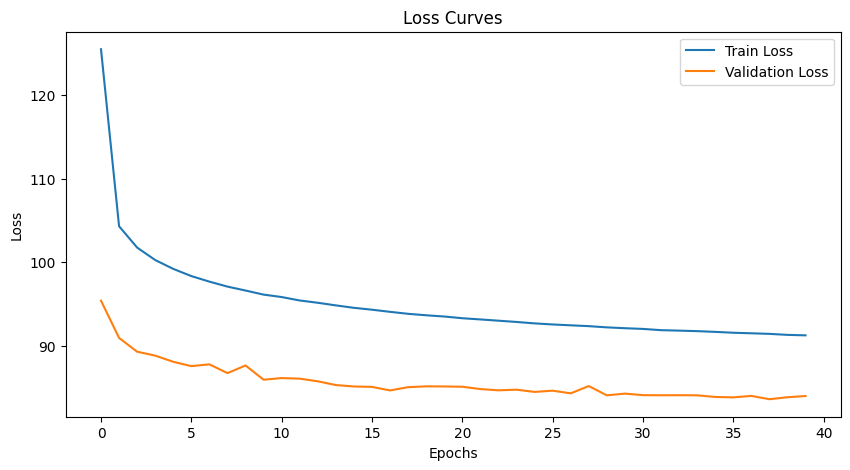

In [10]:
# Графики потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [11]:
import matplotlib.pyplot as plt

def sample_from_cvae(model, latent_dim, target_classes, device='cpu'):

    model.eval()

    with torch.no_grad():
        # Генерируем случайные латентные векторы
        z = torch.randn(len(target_classes), latent_dim).to(device)

        # Преобразуем целевые классы в one-hot формат
        target_classes_tensor = torch.tensor(target_classes, dtype=torch.long, device=device)

        # Генерируем изображения с помощью декодера
        generated_images = model.decode(z, target_classes_tensor)

    # Переходим к формату [batch_size, height, width] для визуализации
    generated_images = generated_images.squeeze(1).cpu()

    # Визуализируем результаты
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(generated_images):
        plt.subplot(1, len(target_classes), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class {target_classes[i]}")
        plt.axis('off')
    plt.show()

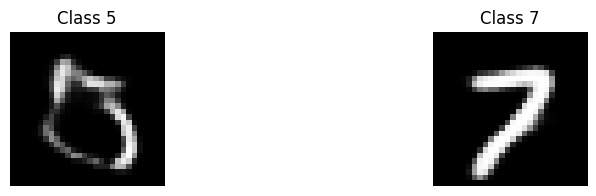

In [12]:
latent_dim = 64  # Размер латентного пространства, заданный при инициализации модели
target_classes = [5, 7]  # Классы для генерации
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Передаем модель на устройство
model = cvae.to(device)

# Сэмплируем изображения
sample_from_cvae(model, latent_dim, target_classes, device)

Splendid! Вы великолепны!


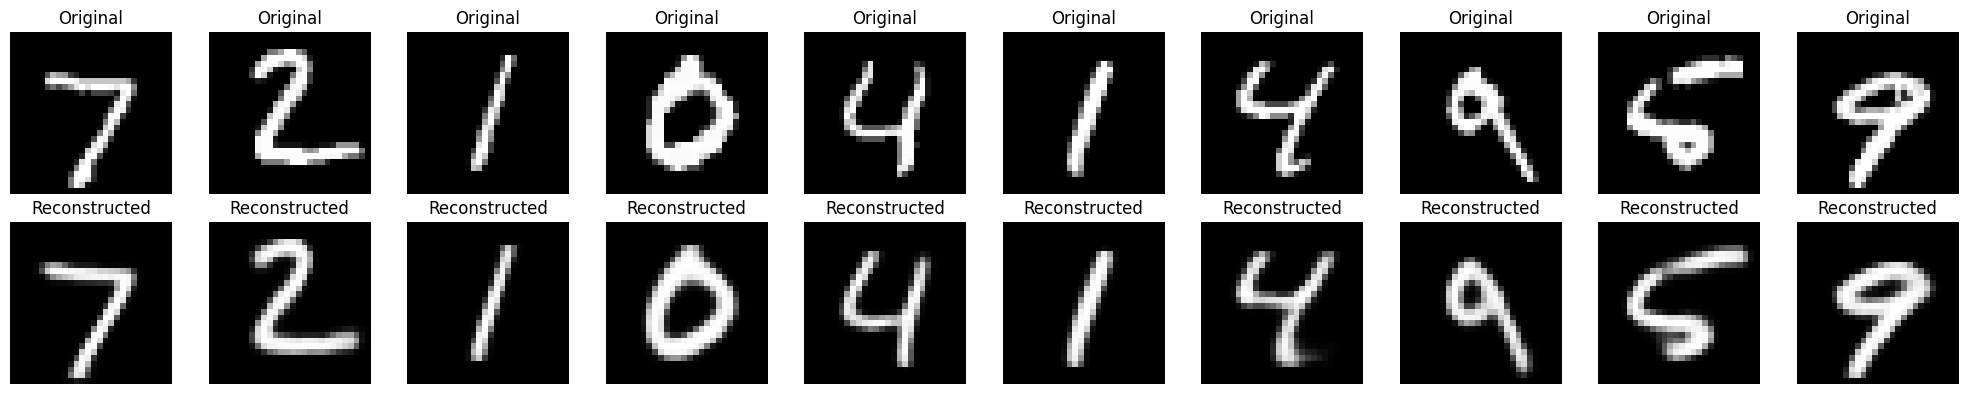

In [15]:
# Проверяем как работает CVAE

# Количество изображений для отображения
num_images = 10

# Переключаем модель в режим оценки
cvae.eval()

# Получение данных из тестового набора
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Кодирование и восстановление
with torch.no_grad():
    # Прямой проход через модель
    mu, logsigma, reconstructions = cvae(images, labels)

# Переводим на CPU для визуализации
images = images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

# Построение графиков
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

for i in range(num_images):
    # Оригинальные изображения
    axes[0, i].imshow(images[i].squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Восстановленные изображения
    axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

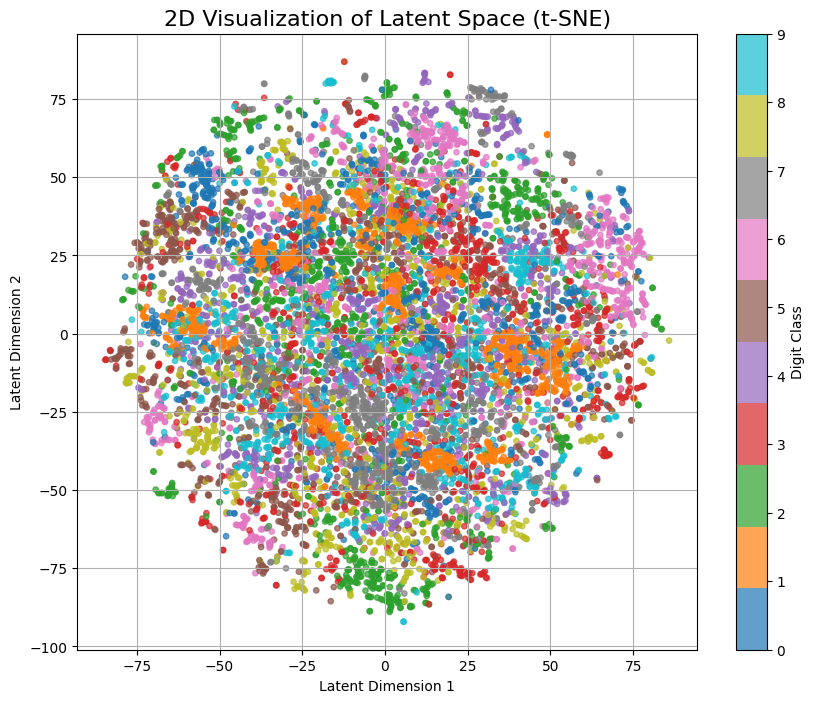

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

cvae.eval()

# Списки для хранения латентных векторов и соответствующих меток классов
latents = []
labels = []

# Получаем латентные векторы для тестового датасета
for images, targets in test_loader:
    images = images.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        # Прямой проход через энкодер
        mu, logsigma = cvae.encode(images, targets)
        latent_vectors = cvae.gaussian_sampler(mu, logsigma).cpu().numpy()  # Семплируем латентные векторы
        latents.append(latent_vectors)
        labels.append(targets.cpu().numpy())  # Сохраняем метки классов

# Преобразуем списки в numpy массивы
latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

# Используем TSNE для уменьшения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)

# Визуализируем латентные представления в 2D пространстве
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=15
)
plt.colorbar(scatter, label="Digit Class")
plt.title("2D Visualization of Latent Space (t-SNE)", fontsize=16)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()


Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

На данной картинке видно, что кластеры классов сильно перекрываются, что характерно для CVAE. Это объясняется тем, что модель использует метки классов как условие, позволяя генерировать данные разных классов из похожих латентных векторов. В отличие от VAE, где кластеры могут быть лучше разделены, в CVAE латентное пространство не обязательно разделяет классы, так как основной фокус на условной генерации.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

**Бонусные задания не выполнял**

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>